In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import dunnett
import seaborn as sns

harvest = {
    'path': './',
    'name': 'commons_harvest__open',
    'trial_ids': ['1', '2', '3', '4', '5'],
    'n': 7,
    'ylim': 800,
    'scratch_id': 'scratch',
}
mushroom = {
    'path': './',
    'name': 'externality_mushrooms__dense',
    'trial_ids': ['1', '2', '3', '4', '5'],
    'n': 5,
    'ylim': 1000,
    'scratch_id': 'scratch',
}
clean = {
    'path': '/scratch_tmp/users/k21075402/tf_2_15',
    'name': 'clean_up',
    'trial_ids': ['756554ae', '96e785e7', 'a1ed7026', 'bb00a28e', 'd604c4e4'],
    'n': 7,
    'n_players_ylim': 2000,
    'ylim': 6000,
    'scratch_id': 'scratch',
}

window = 11
epochs = 300
environment = clean

In [2]:
def load_df(trial_id: str, *, environment: dict[str], independent: bool=False, self_interest: float=None):
    df = pd.read_json(os.path.join(environment['path'], environment['name'], trial_id, 'results.json'), lines=True)
    df['reward'] = df.episode_reward.apply(lambda x: np.mean(x))
    df['self-interest'] = np.round(df['self-interest'], 3)
    df['trial_id'] = trial_id
    if self_interest is None:
        df = df[(df['num_players'] == environment['n'])]
        df = df.sort_values(by=['self-interest', 'training_iteration'], ascending=[False, True])
        df = df.reset_index(drop=True)
        df['iteration'] = df.index + 1
    else:
        df = df[(df['self-interest'] == self_interest)]
        df['iteration'] = df.training_iteration + 300 * (df.num_players - 1)

    df = df.drop(columns=['training_iteration', 'episode_reward', 'episode_lengths'])
    if independent:
        df = df.drop(columns=df.filter(regex='policy_player_').columns)
    else:
        df = df.drop(columns=['policy_default_reward'])
    return df

In [3]:
def plot_num_players(df, environment, rolling: bool = False):
    grouped = df.groupby('trial_id')

    # Plot each group
    fig, ax = plt.subplots(figsize=(4.8, 1.6), facecolor='white')
    for name, group in grouped:
        if rolling:
            result = group['reward'].rolling(window=window, center=True).mean()
            indices = [list(range(epochs*i - window//2 + 1, epochs*i + window//2 +1)) for i in range(1, environment['n'])]
            result.iloc[indices] = np.nan
            result.plot(ax=ax, label=name, legend=False, lw=0.75)
        else:
            group.plot(x='iteration', y='reward', ax=ax, label=name, legend=False, lw=0.75)
    
    ax.set_xlabel('Environment steps (million)')
    ax.set_title('Number of players', fontsize=10, y=1.1)
    ax.set_ylabel('Social welfare')
    step_size = 300
    ax.set_xlim(0, environment['n'] * step_size)
    ylim = environment.get('n_players_ylim', environment['ylim'])
    ax.set_ylim(0, ylim)
    ax.set_xticks(np.arange(0, environment['n'] * step_size + 1, step_size))
    ax.set_xticklabels(np.arange(0, environment['n'] * step_size * 30 * 2000 / 1e6 + 1, step_size * 30 * 2000 / 1e6).astype(int))
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.5)
    ax.xaxis.grid(True, color='grey', linestyle='--', alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())  # Make sure the limits are the same
    ax2.set_yticks(ax.get_yticks())  # Duplicate the tick marks
    
    regions = dict((str(i), i * step_size) for i in range(1, environment['n'] + 1))
    
    for region, position in regions.items():
        # ax.axvline(x=position, color='gray', linestyle='--', alpha=0.5)
        ax.text(position-150, 1.02, region, transform=ax.get_xaxis_transform(), horizontalalignment='center')

    return fig, ax

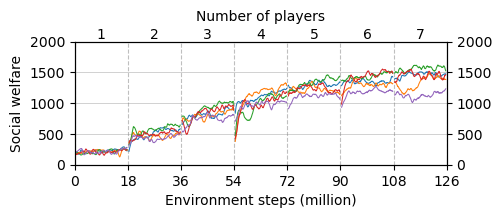

In [4]:
independent = True
self_interest = 1
rolling = True

df = pd.concat([load_df(t, environment=environment, independent=independent, self_interest=self_interest) for t in environment["trial_ids"]])

fig, ax = plot_num_players(df, environment, rolling)

mode = 'independent' if independent else 'self_play'
name = f'num_players_{mode}_{environment["name"]}'
if rolling:
    name += '_rolling'
fig.savefig(name, dpi=300, bbox_inches='tight')

In [5]:
def plot_self_interest(df, envrionment, rolling: bool = False):
    grouped = df.groupby('trial_id')

    fig, ax = plt.subplots(figsize=(4.8, 1.6), facecolor='white')
    for name, group in grouped:
        if rolling:
            result = group['reward'].rolling(window=window, center=True).mean()
            indices = [list(range(epochs*i - window//2 + 1, epochs*i + window//2 +1)) for i in range(1, 10)]
            indices = [idx for sublist in indices for idx in sublist if 0 <= idx < len(result)]
            result.iloc[indices] = np.nan
            result.plot(ax=ax, label=name, legend=False, lw=0.75)
        else:
            group.plot(x='iteration', y='reward', ax=ax, label=name, legend=False, lw=0.75)

    ax.set_xlabel('Environment steps (million)')
    ax.set_title('Self-interest', fontsize=10, y=1.1)
    ax.set_ylabel('Social welfare')
    step_size = 300
    ax.set_xlim(0, 10 * step_size)
    ax.set_ylim(0, environment['ylim'])
    ax.set_xticks(np.arange(0, 10 * step_size + 1, step_size))
    ax.set_xticklabels(np.arange(0, 10 * step_size * 30 * 2000 / 1e6 + 1, step_size * 30 * 2000 / 1e6).astype(int))
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.5)
    ax.xaxis.grid(True, color='grey', linestyle='--', alpha=0.5)
    
    ratio = [20, 10, 5, 3, 5/2, 2, 5/3, 4/3, 1]
    regions = dict((f"{s:.2f}", (1+i) * 300) for i, s in enumerate([1] + [r/(environment['n'] + r - 1) for r in ratio]))
    
    for region, position in regions.items():
        ax.text(position-150, 1.02, region, transform=ax.get_xaxis_transform(), horizontalalignment='center')

    return fig, ax


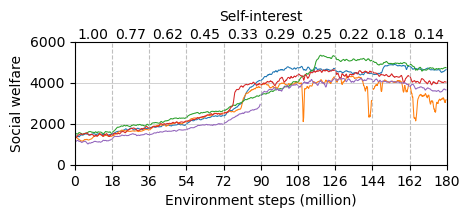

In [6]:
rolling = True

df = pd.concat([load_df(t, environment=environment, independent=independent) for t in environment['trial_ids']])


fig, ax = plot_self_interest(df, environment, rolling=rolling)

mode = 'independent' if independent else 'self_play'
name = f'self_interest_{mode}_{environment["name"]}'
if rolling:
    name += '_rolling'
fig.savefig(name, dpi=300, bbox_inches='tight')

In [17]:
group = df[df['iteration'] % 300 == 0].groupby('self-interest')
df2 = pd.DataFrame(dict((f'{name:.3f}', pd.Series(data.values)) for name, data in group['reward']))
best_group = df2[df2.mean().idxmax()]

data = pd.DataFrame({'mean': df2.mean(), 'std dev': df2.std(), 'dunnet': df2.apply(lambda x: dunnett(x, control=best_group, alternative='less').pvalue[0])}).T
data = data[data.columns[::-1]]

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

data

,1.000,0.769,0.625,0.455,0.333,0.294,0.250,0.217,0.182,0.143
mean,1424.49,1730.89,2041.97,2417.29,3645.89,4173.11,4612.57,4289.15,4313.27,4044.63
std dev,96.68,174.46,211.89,261.92,416.21,374.17,439.84,674.04,504.11,632.38
dunnet,0.00,0.00,0.00,0.00,0.00,0.06,0.50,0.20,0.17,0.07


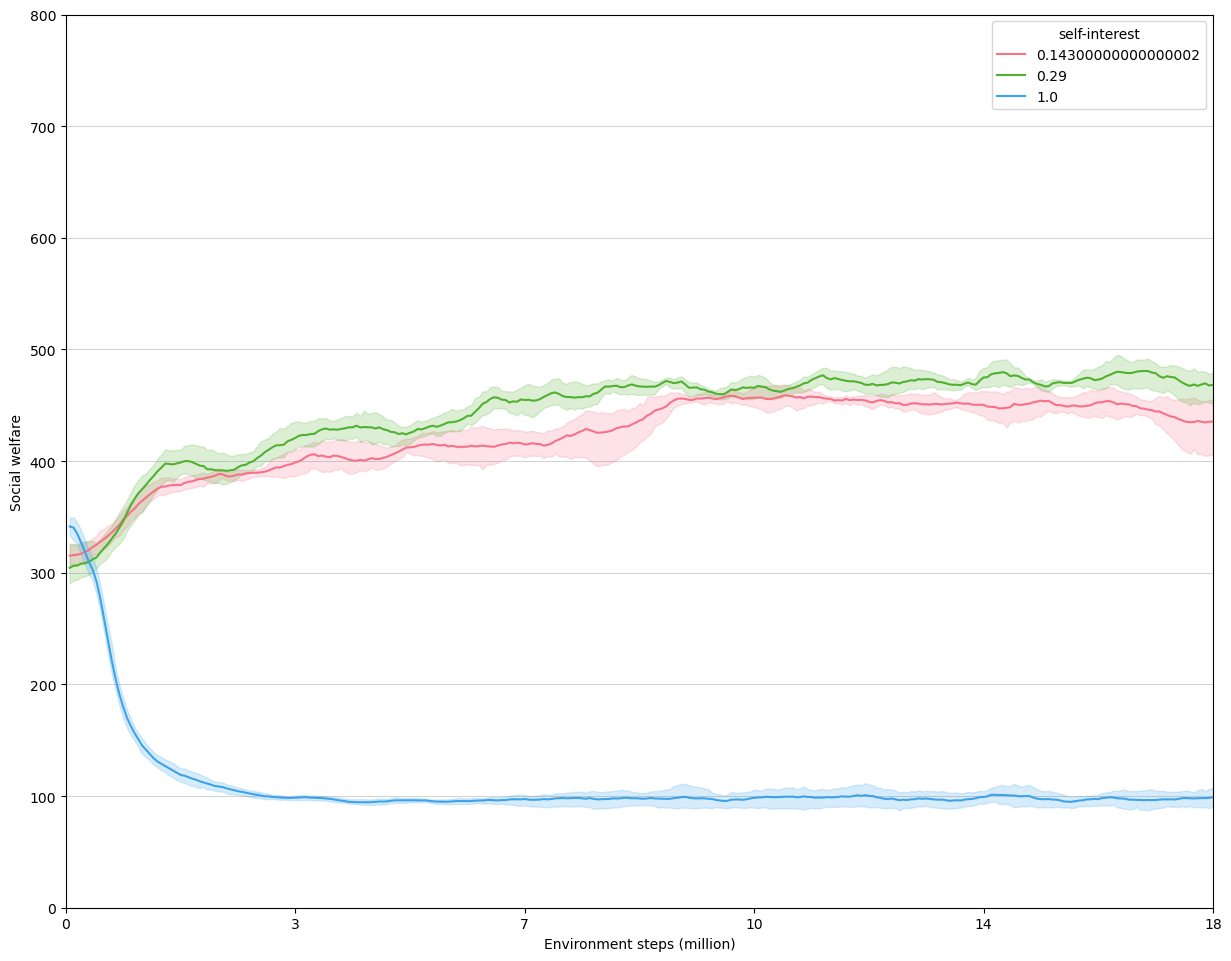

In [13]:
rolling = False
window = 11
n_iterations = 300
pd.set_option('display.precision', 3)

df = pd.read_json(os.path.join(environment['path'], environment['name'], environment['scratch_id'], 'results.json'), lines=True)
df['reward'] = df.episode_reward.apply(lambda x: np.mean(x))
df = df[['reward', 'training_iteration', 'self-interest']]
df = df[df['training_iteration'] <= epochs]

self_interest_values = df['self-interest'].unique()

# assign each training_iteration to a run
# because some runs are in parallel, the results are not necessarily sequential
# they are ordered
def assign_runs(df, s):
    df_s = df[df['self-interest'] == s].copy()
    n = len(df_s[df_s['training_iteration'] == 1])

    df_s['idx'] = df_s.index
    df_s = df_s.sort_values(['training_iteration', 'idx'], kind='mergesort')
    df_s = df_s.reset_index(drop=True)
    df_s['run'] = df_s.index % n
    df_s = df_s.drop(columns=['idx'])

    df_s['smoothed_reward'] = df_s.groupby('run')['reward'].transform(lambda x: x.rolling(window=window, center=True, min_periods=1).mean())
    return df_s

dfs = [assign_runs(df, s) for s in self_interest_values]
df = pd.concat(dfs, axis=0, ignore_index=True)

# fig, ax = plt.subplots(figsize=(4.8, 1.6), facecolor='white')
fig, ax = plt.subplots(figsize=(14.8, 11.6), facecolor='white')

colours = sns.color_palette("husl", len(self_interest_values))

sns.lineplot(
    data=df,
    x='training_iteration',
    y='smoothed_reward',
    hue='self-interest',
    errorbar=('ci', 95),  # 95% confidence interval
    palette=colours,
    # estimator='mean',
    # color='blue',
    # n_boot=1000,
)

ax.set_xlabel('Environment steps (million)')
ax.set_ylabel('Social welfare')
ax.set_xlim(0, epochs)
ax.set_ylim(0, environment['ylim'])
ax.set_xticks(np.arange(0, epochs + 1, epochs / 5))
ax.set_xticklabels(np.arange(0, epochs * 30 * 2000 / 1e6 + 1, epochs / 5 * 30 * 2000 / 1e6).astype(int))
ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.5)
 
fig.savefig(f'scratch_{environment["name"]}', dpi=300, bbox_inches='tight')

In [75]:
dfs[0]

,reward,training_iteration,self-interest,run
0,286.300,1,0.29,0
1,342.033,1,0.29,1
2,289.900,1,0.29,2
3,282.967,1,0.29,3
4,278.733,2,0.29,0
...,...,...,...,...
1195,507.367,299,0.29,3
1196,491.467,300,0.29,0
1197,492.800,300,0.29,1
1198,468.600,300,0.29,2


In [74]:
dfs[0].groupby('run')['reward'].rolling(window=window, center=True, min_periods=1).mean()

run      
0    0       280.411
     4       283.117
     8       285.420
     12      289.240
     16      294.313
              ...   
3    1183    464.953
     1187    475.233
     1191    485.680
     1195    485.817
     1199    493.000
Name: reward, Length: 1200, dtype: float64

In [39]:
df

,reward,training_iteration,self-interest,run
0,286.300000,1,0.290,0
1,342.033333,1,0.290,1
2,289.900000,1,0.290,2
3,282.966667,1,0.290,3
4,278.733333,2,0.290,0
...,...,...,...,...
5195,381.366667,299,0.143,3
5196,464.766667,300,0.143,0
5197,443.666667,300,0.143,1
5198,467.800000,300,0.143,2


In [77]:
smoothed_rewards

[run      
 0    0       280.411
      4       283.117
      8       285.420
      12      289.240
      16      294.313
               ...   
 3    1183    464.953
      1187    475.233
      1191    485.680
      1195    485.817
      1199    493.000
 Name: reward, Length: 1200, dtype: float64,
 run      
 0    0       335.411
      4       346.142
      8       351.760
      12      359.387
      16      357.733
               ...   
 3    1183     97.467
      1187     99.113
      1191     98.860
      1195     92.925
      1199     93.822
 Name: reward, Length: 1200, dtype: float64,
 run      
 0    0       307.022
      4       310.700
      8       310.693
      12      313.847
      16      315.313
               ...   
 3    1183    389.087
      1187    388.367
      1191    394.373
      1195    394.000
      1199    401.100
 Name: reward, Length: 1200, dtype: float64]